<a href="https://colab.research.google.com/github/Jong-Chan-Lee/data/blob/main/CART_MultiClass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from collections import Counter
import copy

class MyDTreeClassifier:
  def __init__(self, max_depth):
    self.max_depth = max_depth
    self.u_class = None
    self.estimator1 = dict()
    self.estimator2 = dict()
    self.feaure = None
    self.target = None

  def gini_index(self, leaf):
    n = leaf.shape[0]
    gini = 1.0
    for c in self.u_class:
      cnt = (self.target[leaf] == c).sum()
      gini -= (cnt / n) ** 2
    return gini

  def node_split(self, did):
    n = did.shape[0]
    p_gini = self.gini_index(did)
    max_ig = -999999
    for fid in range(self.feature.shape[1]):
      x_feat = self.feature[did, fid].copy()
      x_uniq = np.unique(x_feat)
      s_point = [np.mean([x_uniq[i-1], x_uniq[i]]) for i in range(1, len(x_uniq))]
      for p in s_point:
        left = did[np.where(x_feat <= p)[0]]
        right = did[np.where(x_feat > p)[0]]
        l_gini = self.gini_index(left)
        r_gini = self.gini_index(right)
        ig = p_gini - (l_gini * left.shape[0] / n) - (r_gini * right.shape[0] / n)
        if ig > max_ig:
          max_ig = ig
          b_fid = fid
          b_point = p
          b_left = left
          b_right = right
    if max_ig > 0.:
      return {'fid':b_fid, 'split_point':b_point, 'left':b_left, 'right':b_right}
    else:
      return None

  def recursive_split(self, node, curr_depth):
    left = node['left']
    right = node['right']
    if curr_depth >= self.max_depth:
      return
    s = self.node_split(left)
    if isinstance(s, dict):
      node['left'] = s
      self.recursive_split(node['left'], curr_depth+1)
    s = self.node_split(right)
    if isinstance(s, dict):
      node['right'] = s
      self.recursive_split(node['right'], curr_depth+1)

  def majority_vote(self, did):
    c = Counter(self.target[did])
    return c.most_common(1)[0][0]

  def update_leaf(self, d):
    if isinstance(d, dict):
      for key, value in d.items():
        if key == 'left' or key == 'right':
          rtn = self.update_leaf(value)
          if rtn[0] == 1:
            d[key] = rtn[1]
      return 0, 0
    else:
      return 1, self.majority_vote(d)

  def fit(self, x, y):
    self.feature = x
    self.target = y
    self.u_class = np.unique(y)
    root = self.node_split(np.arange(x.shape[0]))
    if isinstance(root, dict):
      self.recursive_split(root, curr_depth=1)
    self.estimator1 = root
    self.estimator2 = copy.deepcopy(self.estimator1)
    self.update_leaf(self.estimator2)
    return self.estimator2

  def x_predict(self, p, x):
    if x[p['fid']] <= p['split_point']:
      if isinstance(p['left'], dict):
        return self.x_predict(p['left'], x)
      else:
        return p['left']
    else:
      if isinstance(p['right'], dict):
        return self.x_predict(p['right'], x)
      else:
        return p['right']

  def predict(self, x_test):
    p = self.estimator2
    y_pred = [self.x_predict(p,x) for x in x_test]
    return np.array(y_pred)

In [2]:
import numpy as np
#from MyDTreeClassifier Import MyDTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import tree
import pprint

x, y = load_iris(return_X_y=True)
x_train, x_test, y_train, y_test = train_test_split(x, y)

model1 = MyDTreeClassifier(max_depth=3)
model1.fit(x_train, y_train)
y_pred1 = model1.predict(x_test)
accuracy1 = (y_test == y_pred1).mean()
print('\nAccuracy of Model-1 = {:.3f}'.format(accuracy1))

model2 = DecisionTreeClassifier(max_depth=3)
model2.fit(x_train, y_train)
y_pred2 = model2.predict(x_test)
accuracy2 = (y_test == y_pred2).mean()
print('\nAccuracy of Model-2 = {:.3f}'.format(accuracy2))


Accuracy of Model-1 = 1.000

Accuracy of Model-2 = 1.000



MytreeClassifier: estimator2:
{'fid': 2,
 'split_point': 2.45,
 'left': 0,
 'right': {'fid': 3,
           'split_point': 1.75,
           'left': {'fid': 2, 'split_point': 4.9, 'left': 1, 'right': 2},
           'right': {'fid': 2, 'split_point': 4.85, 'left': 2, 'right': 2}}}


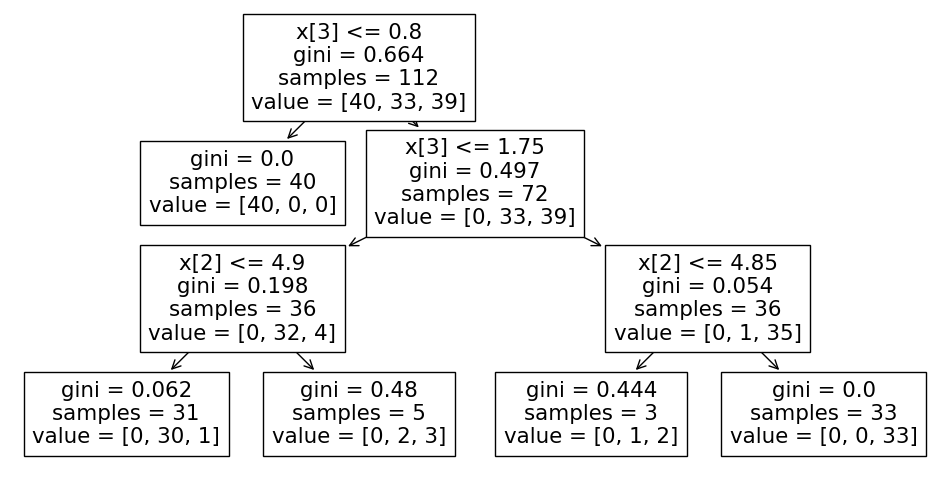

In [3]:
depth=3
sk_model = DecisionTreeClassifier(max_depth=depth, random_state=1)
sk_model.fit(x_train, y_train)
sk_pred = sk_model.predict(x_test)
acc = (y_test == sk_pred).mean()
#print('DecisionTreeClassifier: accuracy =.3f}'.format(acc))
print('\nMytreeClassifier: estimator2:')
pprint.pprint(model1.estimator2, sort_dicts=False)
plt.figure(figsize=(12,6))
tree.plot_tree(sk_model)
plt.show()